# Modificando o Modelo: Adaptando a quarentena ao RJ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates
from scipy.integrate import solve_ivp
import plotly.express as px
from jia_cidades import F_Quarentena, F, multi_regime
from jia import new_deaths as new_deaths_1_cidade## ESTAMOS DANDO IMPORT NO JIA
from jia import new_diagn as new_diagn_1_cidade
from jia import tot_deaths 

sns.set_style("darkgrid")

## Fluxogramas

<img src='images/diagrama_q.png' width = '750px' height = '750px' style='margin: 0 auto'>

<img src='images/diagrama_q2.png' width = '750px' height = '750px' style='margin: 0 auto'>

In [2]:
# Taxa de subnotificação
taxa_subn   = 8
# Proporção de infectados assintomáticos
prop_assint = 0.80

In [3]:
# Idx       :         0,    1,     2,    3,     4,    5,     6,      7,    8,      9,     10,     11,     12,    13
# Parâmetros:      betaS, theta,  p, lambda, sigma, rho,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD, betaQ
params_rio_base = (1e-7,  1/10, 1/4,  1/6,   1/7, 0.94, 1/100, 0.0996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017, 1e-7/7)

In [4]:
# Dados para a cidade do Rio de Janeiro,
# IBGE 2019 (estimativa)
pop_Rio = 6718903
# 29 de Março
diagn_Rio, recup_Rio = 489, 16
infect_Rio = diagn_Rio*(taxa_subn-1)*(1 - prop_assint)
assint_Rio = diagn_Rio*(taxa_subn-1)*prop_assint
expostos_Rio = diagn_Rio*7
quarentena_Rio = 0.6 * pop_Rio

suscetiveis_Rio = pop_Rio - (quarentena_Rio + expostos_Rio + assint_Rio + infect_Rio + diagn_Rio + recup_Rio)

CI = [suscetiveis_Rio, quarentena_Rio, expostos_Rio, assint_Rio, infect_Rio, diagn_Rio, recup_Rio]

### Dados Reais para o Rio de Janeiro

Dados de novos casos por dia de `Diagnosticados` e `Óbitos`

In [5]:
# Do dia 29/04 até o dia 12/04, dados da prefeitura
dados_Rio = [
    [26, 38, 30, 114, 110, 60, 115, 86, 42, 141, 198, 184, 175, 97, 91, 326, 71, 126],
    [1, 3, 2, 4,   7,  5,   2,  4,  5,  12,  14,   9,  10,  6,  8,   9, 25,  27]
]

In [6]:
T_fim = len(dados_Rio[0])

start = dt.datetime.strptime("29-03-2020", "%d-%m-%Y")
then = start + dt.timedelta(days=T_fim)
days = mdates.drange(start,then,dt.timedelta(days=1))

In [7]:
# Supondo mantida a quarentena
f_rio_base = lambda t,v: F_Quarentena(t,v, *params_rio_base)
results_base_quarentena = solve_ivp(f_rio_base, (1,T_fim), CI, t_eval=range(1,T_fim+1))
g_rio_base = lambda t, v: F(t, v, *params_rio_base[:-1])
results_base_jia = solve_ivp(g_rio_base, (1, T_fim), CI, t_eval = range(1, T_fim+1))

In [8]:
diagn_quarentena = new_diagn_1_cidade(results_base_quarentena.y, params_rio_base)
deaths_quarentena = new_deaths_1_cidade(results_base_quarentena.y, params_rio_base)

diagn_jia = new_diagn_1_cidade(results_base_jia.y, params_rio_base)
deaths_jia = new_deaths_1_cidade(results_base_jia.y, params_rio_base)

titles = ['Novos diagnósticos: Quarentena tipo Rio', 'Novos diagnósticos: Quarentena tipo Jia', 
          'Diferença de diagnósticos entre tipos de quarentena', 'Novos óbitos: Quarentena tipo Rio', 
          'Novos óbitos: Quarentena tipo Jia', 'Diferença de óbitos entre tipos de quarentena']

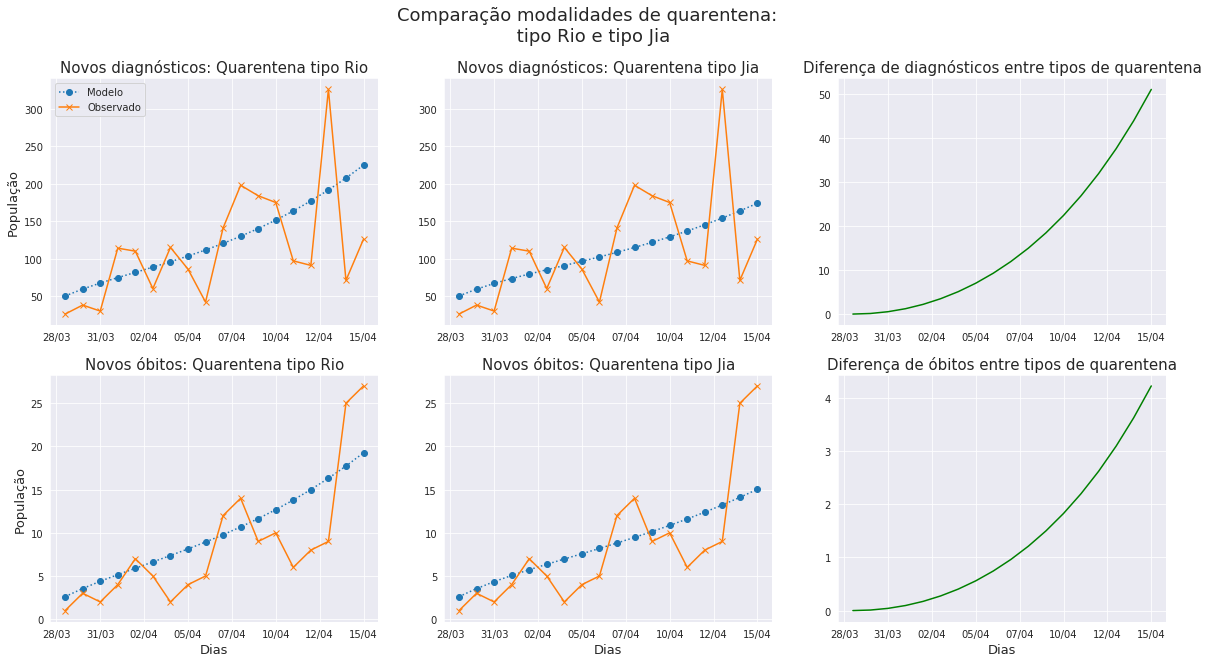

In [9]:
fig, ((ax1,ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols=3, figsize=(20,10))

fig.suptitle('Comparação modalidades de quarentena: \n tipo Rio e tipo Jia', fontsize = 18)

ax1.plot(days, diagn_quarentena,        'o:', label='Modelo')
ax1.plot(days, dados_Rio[0], 'x-', label='Observado')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.grid(color = 'white')
ax1.set_title('Novos diagnósticos: Rio de Janeiro', fontsize = 15)
ax1.set_ylabel('População', fontsize = 13)
cidade = 'São Paulo'

ax4.plot(days, deaths_quarentena,       'o:', label = 'Modelo')
ax4.plot(days, dados_Rio[1], 'x-', label='Observado')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax4.grid(color = 'white')
ax4.set_ylabel('População', fontsize = 13)
ax4.set_xlabel('Dias', fontsize = 13)

ax2.plot(days, diagn_jia,        'o:', label='Modelo')
ax2.plot(days, dados_Rio[0], 'x-', label='Observado')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.grid(color = 'white')

ax5.plot(days, deaths_jia,       'o:', label = 'Modelo')
ax5.plot(days, dados_Rio[1], 'x-', label='Observado')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax5.grid(color = 'white')
ax5.set_xlabel('Dias', fontsize = 13)

ax3.plot(days, np.abs(diagn_jia-diagn_quarentena), label = 'Modelo', color = 'green')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax3.grid(color = 'white')

ax6.plot(days, np.abs(deaths_jia-deaths_quarentena), label = 'Modelo', color = 'green')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax6.grid(color = 'white')
ax6.set_xlabel('Dias', fontsize = 13)
eixos = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, eixo in enumerate(eixos):
    eixo.set_title(titles[i], fontsize = 15)
ax1.legend()
plt.show()